# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gymnasium: https://github.com/Farama-Foundation/Gymnasium (**New package to install**)
    - To install the base Gymnasium library, use **pip install gymnasium**

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from mpl_toolkits.mplot3d import Axes3D

# Q2: Backjack 

Please note, since there is no scaffolding code for this question. Please make sure your implementation is well-tested and the comments are clear to understand. 

In [22]:
# test code for using the "Backjack" implementation from OpenAI
env = gym.make("Blackjack-v1")
env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    action = env.action_space.sample()
    
    # interact with the envrionment
    next_s, reward, done, info, _ = env.step(action)
    
    # print info
    print(f"t = {t}, next_state = {next_s}, reward = {reward}, done = {done}")
    
    # check termination
    if done:
        env.reset()

t = 0, next_state = (11, 6, 0), reward = -1.0, done = True
t = 1, next_state = (11, 4, 0), reward = 1.0, done = True
t = 2, next_state = (21, 8, 0), reward = 0.0, done = False
t = 3, next_state = (26, 8, 0), reward = -1.0, done = True
t = 4, next_state = (16, 8, 0), reward = -1.0, done = True
t = 5, next_state = (20, 10, 0), reward = 0.0, done = True
t = 6, next_state = (13, 4, 0), reward = 0.0, done = False
t = 7, next_state = (13, 4, 0), reward = -1.0, done = True
t = 8, next_state = (15, 4, 1), reward = 1.0, done = True
t = 9, next_state = (28, 4, 0), reward = -1.0, done = True


## (a): Implement first-visit Monte-Carlo policy evaluation (See pseudocode in 5.1). 

Please read Example 5.1 and reproduce Figure 1. The policy to be evaluated is the "sticks only on 20 or 21". Please only reproduce the plots after 500, 000 episodes (Usable ace and No usable ace). 

In [ ]:
""" CODE HERE YOUR IMPLEMENTATION for Q2-(a) """

def policy(state):
    player_sum, dealer_showing, usable_ace = state
    if player_sum >= 20:
        return 0  # "Stick"
    else:
        return 1  # "Hit"

def mc_p_eval(env, policy, num_episodes=500000):
    V={}
    returns={}

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_sar = []

        while not done:
            action = policy(state)
            next_state, reward, done, truncated, info = env.step(action)
            episode_sar.append((state, action, reward))
            state = next_state

        G = sum([sar[2] for sar in episode_sar])

        visited_states = set()

        for (s,a,r) in episode_sar:
            if (s,a) not in visited_states:
                visited_states.add(s)

                if s not in V:
                    V[s] = 0.0
                    returns[s] = 0.0
                returns[s] += 1
                V[s] += (G - V[s]) / returns[s]
    return V

def plot_value_function(V):

    x_usable, y_usable, z_usable = [], [], []
    x_not_usable, y_not_usable, z_not_usable = [], [], []

    for (player_sum, dealer_showing, usable_ace), value in V.items():
        # We only care about states in typical Blackjack ranges
        if 12 <= player_sum <= 21 and 1 <= dealer_showing <= 10:
            if usable_ace:
                x_usable.append(player_sum)
                y_usable.append(dealer_showing)
                z_usable.append(value)
            else:
                x_not_usable.append(player_sum)
                y_not_usable.append(dealer_showing)
                z_not_usable.append(value)

    fig = plt.figure(figsize=(12,5))

    # Usable Ace
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_trisurf(x_usable, y_usable, z_usable, cmap='viridis')
    ax1.set_title("Value Function (Usable Ace)")
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_zlabel("V(s)")

    # No Usable Ace
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_trisurf(x_not_usable, y_not_usable, z_not_usable, cmap='viridis')
    ax2.set_title("Value Function (No Usable Ace)")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_zlabel("V(s)")

    plt.show()



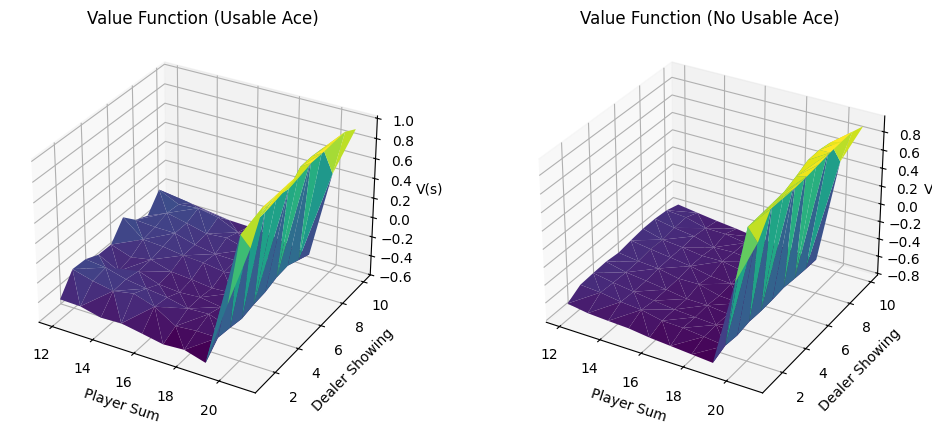

In [24]:
env = gym.make("Blackjack-v1")
V_estimated = mc_p_eval(env, policy, num_episodes=500000)
plot_value_function(V_estimated)

## (b): Implement first-visit Monte-Carlo control with exploring starts (Monte-Carlo ES in 5.3). 

Please read the Example 5.1 and reproduce the Figure 5.2

In [68]:
""" CODE HERE YOUR IMPLEMENTATION for Q2-(b) """
def epsilon_greedy_action(state, Q, epsilon=0.1):

    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])
    else:
        q0 = Q.get((state, 0), 0.0)
        q1 = Q.get((state, 1), 0.0)
        return 0 if q0 >= q1 else 1
    
def mc_es(env, num_episodes=500_000, epsilon=0.1, gamma=1.0):

    Q = {}              # Maps (state, action) to value estimates
    returns_count = {}  # Counts for each (state, action) pair
    policy = {}         # Current greedy policy: state -> action

    for episode_i in range(num_episodes):
        episode = []
        state, _ = env.reset()
        
        # Exploring Start
        action = np.random.choice([0, 1])
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state

        # Follow e-greedy policy for the rest of the episode
        while not done:
            action = epsilon_greedy_action(state, Q, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Compute Return and Update Q (First-Visit MC)
        G = 0.0
        visited_sa = set()
        # Iterate backward over the episode
        for s, a, r in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited_sa:
                visited_sa.add((s, a))
                if (s, a) not in Q:
                    Q[(s, a)] = 0.0
                    returns_count[(s, a)] = 0
                returns_count[(s, a)] += 1
                Q[(s, a)] += (G - Q[(s, a)]) / returns_count[(s, a)]
                # Update the policy for state s to be greedy with respect to Q.
                q0 = Q.get((s, 0), 0.0)
                q1 = Q.get((s, 1), 0.0)
                best_action = 0 if q0 >= q1 else 1
                policy[s] = best_action

    return Q, policy

def plot_policy(policy):

    # Create grids for the two cases.
    policy_usable = np.zeros((10, 10))      # Rows: player_sum 12..21, Columns: dealer showing 1..10
    policy_non_usable = np.zeros((10, 10))

    for player_sum in range(12, 22):
        for dealer_showing in range(1, 11):
            for ace_flag in [True, False]:
                state = (player_sum, dealer_showing, ace_flag)
                action = policy.get(state, 0)
                if ace_flag:
                    policy_usable[player_sum - 12, dealer_showing - 1] = action
                else:
                    policy_non_usable[player_sum - 12, dealer_showing - 1] = action

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Usable Ace
    im1 = ax1.imshow(policy_usable, cmap='gray', origin='lower', extent=[1, 10, 12, 21])
    ax1.set_title("Optimal Policy (Usable Ace)\n0: Stick, 1: Hit")
    ax1.set_xlabel("Dealer Showing")
    ax1.set_ylabel("Player Sum")
    cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 1])
    cbar1.ax.set_yticklabels(['Stick', 'Hit'])

    # No Usable Ace
    im2 = ax2.imshow(policy_non_usable, cmap='gray', origin='lower', extent=[1, 10, 12, 21])
    ax2.set_title("Optimal Policy (No Usable Ace)\n0: Stick, 1: Hit")
    ax2.set_xlabel("Dealer Showing")
    ax2.set_ylabel("Player Sum")
    cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0, 1])
    cbar2.ax.set_yticklabels(['Stick', 'Hit'])

    plt.tight_layout()
    plt.show()


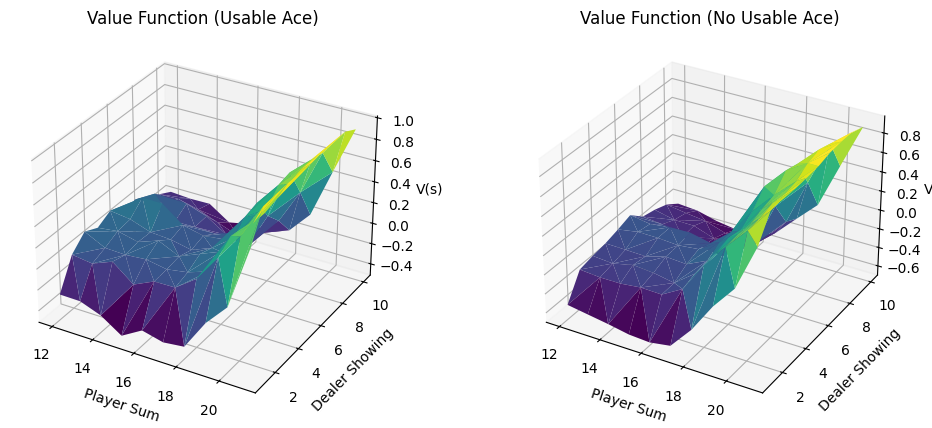

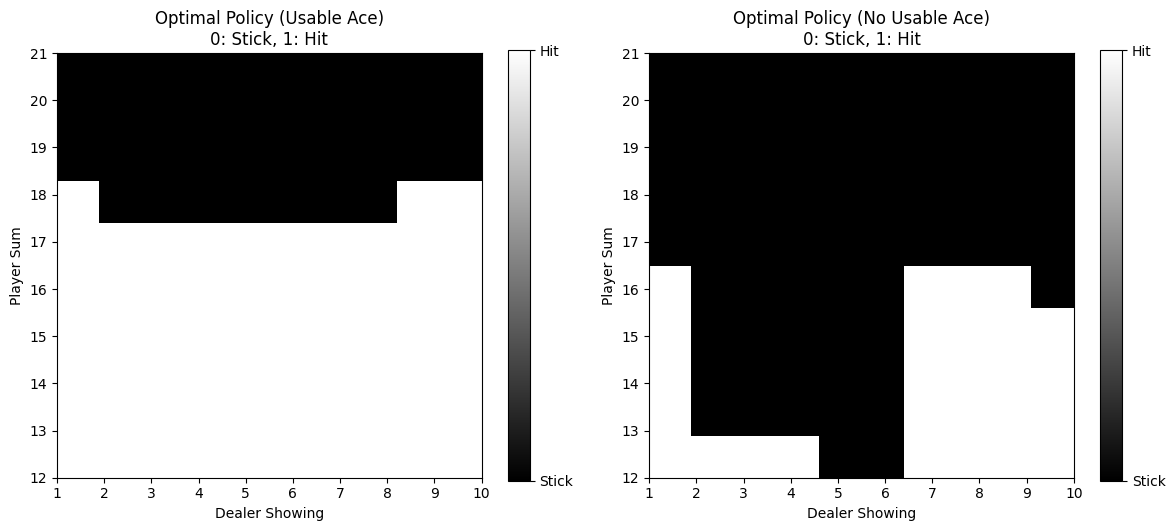

In [69]:
np.random.seed(0)
env = gym.make("Blackjack-v1")
Q, policy = mc_es(env, num_episodes=500000, epsilon=0.1, gamma=1.0)

V = {}
for (state, action), value in Q.items():
    if state not in V:
        V[state] = value
    else:
        V[state] = max(V[state], value)

plot_value_function(V)
plot_policy(policy)


# Q3: Four Rooms, re-visited

In [27]:
"""DO NOT CHANGE"""
class FourRooms(object):
    def __init__(self):
        # define the four room as a 2-D array for easy state space reference and visualization
        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # find the positions for all empty cells
        # note that: the origin for a 2-D numpy array is located at top-left while the origin for the FourRooms is at
        # the bottom-left. The following codes performs the re-projection.
        empty_cells = np.where(self.four_room_space == 0.0)
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]

        # define the action space
        self.action_space = {'LEFT': np.array([-1, 0]),
                             'RIGHT': np.array([1, 0]),
                             'DOWN': np.array([0, -1]),
                             'UP': np.array([0, 1])}

        # define the start state
        self.start_state = [0, 0]

        # define the goal state
        self.goal_state = [10, 10]

        # maximal time steps
        self.max_time_steps = 459

        # track the time step
        self.t = 0

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        state = self.start_state
        # reset the reward to be 0
        reward = 0
        # reset the termination flag
        done = False
        # reset the time step tracker
        self.t = 0
        return state, reward, done

    def step(self, state, act):
        """
        Args:
            state: a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act: a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state: a list variable containing x, y integer coordinates (i.e., [1, 1])
            reward: an integer. it can be either 0 or 1.
        """
        # Increase the time step
        self.t += 1

        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if act == "LEFT" or act == "RIGHT":
                act = np.random.choice(["UP", "DOWN"], 1)[0]
            else:
                act = np.random.choice(["RIGHT", "LEFT"], 1)[0]

        # Compute the next state
        next_state = self.take_action(state, act)

        # Compute the reward
        reward = 1.0 if next_state == [10, 10] else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if next_state == [10, 10] or self.t == self.max_time_steps:
            done = True
        else:
            done = False

        return next_state, reward, done

    def take_action(self, state, act):
        """
        Input args:
            state (list): a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act (string): a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state (list): a list variable containing x, y integer coordinates (i.e., [1, 1])
        """
        state = np.array(state)
        next_state = state + self.action_space[act]
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy

In [ ]:
def epsilon_soft_policy(Q, state, actions, epsilon):
    """Compute an ε-soft policy for a state given the current Q-values and ε."""
    nA = len(actions)

    # Start with uniform probability due to ε
    policy = {a: epsilon / nA for a in actions}

    # Identify the best action(s) according to current Q-values
    best_value = max(Q[state][a] for a in actions)
    best_actions = [a for a in actions if Q[state][a] == best_value]

    # Add the remaining probability (1-ε) evenly among the best actions
    for a in best_actions:
        policy[a] += (1 - epsilon) / len(best_actions)
    return policy

def choose_action(policy):
    """Select an action based on the provided probability distribution."""
    actions = list(policy.keys())
    probabilities = list(policy.values())
    return np.random.choice(actions, p=probabilities)

def run_episode(env, Q, epsilon, gamma):
    """Generate an episode following the current ε-soft policy and return the episode and its discounted return.
    
    The episode is a list of (state, action, reward) tuples.
    """
    episode = []
    state, _, done = env.reset()
    state = tuple(state)
    while not done:
        if state not in Q:
            # Initialize Q for unseen states
            Q[state] = {a: 0.0 for a in env.action_space.keys()}
        policy = epsilon_soft_policy(Q, state, list(env.action_space.keys()), epsilon)
        action = choose_action(policy)
        next_state, reward, done = env.step(list(state), action)
        episode.append((state, action, reward))
        state = tuple(next_state)
    # Compute total discounted return for the episode
    G = 0
    for t, (_, _, reward) in enumerate(episode):
        G += (gamma ** t) * reward
    return episode, G

def monte_carlo_control(env, num_episodes, epsilon, gamma):
    """Perform on-policy first-visit Monte Carlo control.
    
    Returns:
      - Q: The learned action-value function.
      - returns_per_episode: A list containing the discounted return of each episode.
    """
    Q = {}
    # Dictionaries to keep track of returns for each (state, action)
    returns_sum = {}
    returns_count = {}
    returns_per_episode = []

    for i in range(num_episodes):
        episode, G_episode = run_episode(env, Q, epsilon, gamma)
        returns_per_episode.append(G_episode)
        visited = set()
        G = 0
        # Loop backward through the episode to compute cumulative return efficiently.
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                if (state, action) not in returns_sum:
                    returns_sum[(state, action)] = 0.0
                    returns_count[(state, action)] = 0
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                # Update Q-value as the average of all returns observed for (state, action)
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
    return Q, returns_per_episode

def run_trials(epsilon, num_trials, num_episodes, gamma):
    """Run multiple independent trials and return the per-episode returns for each trial."""
    returns_all = []
    for trial in range(num_trials):
        env = FourRooms()
        _, returns_per_episode = monte_carlo_control(env, num_episodes, epsilon, gamma)
        returns_all.append(returns_per_episode)
    returns_all = np.array(returns_all)
    avg_returns = np.mean(returns_all, axis=0)
    std_returns = np.std(returns_all, axis=0)
    return avg_returns, std_returns

def plot_learning_curves(epsilon_values, num_trials, num_episodes, gamma):
    plt.figure(figsize=(10, 6))
    episodes = np.arange(num_episodes)
    for epsilon in epsilon_values:
        avg_returns, std_returns = run_trials(epsilon, num_trials, num_episodes, gamma)
        plt.plot(episodes, avg_returns, label=f'ε = {epsilon}')
        
        # Compute 95% confidence intervals
        ci = 1.96 * (std_returns / np.sqrt(num_trials))
        plt.fill_between(episodes, avg_returns - ci, avg_returns + ci, alpha=0.3)
    plt.xlabel('Episodes')
    plt.ylabel('Discounted Return')
    plt.title('Learning Curves for First-Visit Monte Carlo Control in FourRooms\n(with 95% Confidence Bands)')
    plt.legend()
    plt.grid(True)
    plt.show()




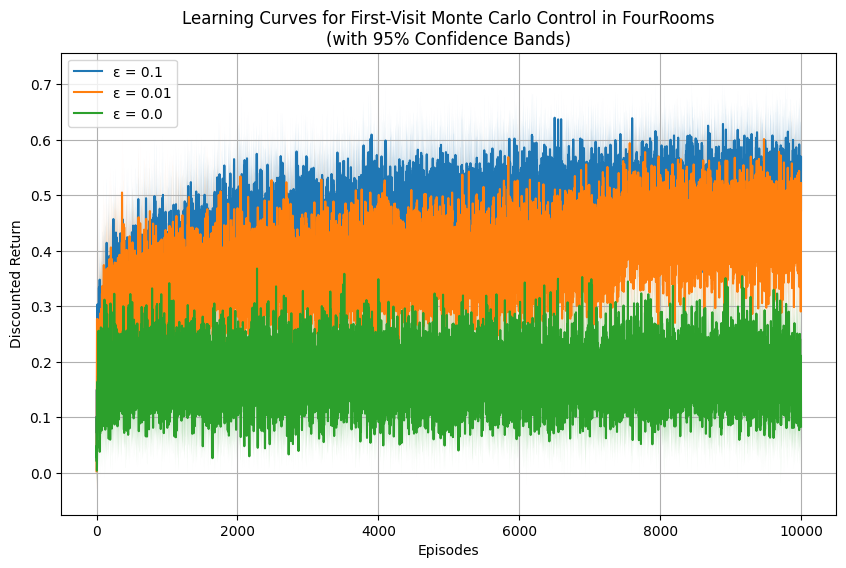

In [ ]:
num_trials = 10         
num_episodes = 10000 
gamma = 0.99
epsilon_values = [0.1, 0.01, 0.0]

plot_learning_curves(epsilon_values, num_trials, num_episodes, gamma)


## Q5: Racktrack

Please note, we provde you with the implementation of the two Racetrack domains in the Figure 5.5.

In [29]:
# Define the Racetrack domain 1
racetrack_v1_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]])

racetrack_v2_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

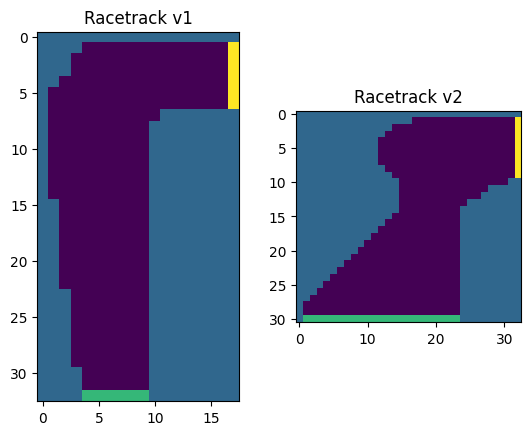

In [30]:
fig, arr = plt.subplots(1, 2)
arr[0].set_title("Racetrack v1")
arr[0].imshow(racetrack_v1_arr)
arr[1].set_title("Racetrack v2")
arr[1].imshow(racetrack_v2_arr)
plt.show()

In [31]:
"""Implementation of the Racetrack environment. Do not change"""
class Racetrack(object):
    def __init__(self, version):
        # Load the pre-defined the domain having the following representation
        #   - 1: track cell
        #   - 0: empty cell
        #   - 2: empty cell on the start line
        #   - 3: empty cell on the finish line
        if version == "v1":
            self.domain_arr = racetrack_v1_arr.copy()
        else:
            self.domain_arr = racetrack_v2_arr.copy()

        # domain size
        self.height, self.width = self.domain_arr.shape

        # State space consists of:
        # Agent location
        self.empty_cell_locs = self.render_cell_locations(val=0.0)
        self.track_cell_locs = self.render_cell_locations(val=1.0)
        self.start_cell_locs = self.render_cell_locations(val=2.0)
        self.finish_cell_locs = self.render_cell_locations(val=3.0)

        # Action space
        self.action_space = [[-1, -1], [-1, 0], [-1, 1],
                             [0, -1], [0, 0], [0, 1],
                             [1, -1], [1, 0], [1, 1]]

        # construct the state space
        self.state_space = []
        for loc in self.start_cell_locs + self.empty_cell_locs + self.finish_cell_locs:
            for i in range(5):
                for j in range(5):
                    self.state_space.append(loc + [i, j])

        # track the agent's location
        self.state = None
        self.action = None
        self.t = None

    def reset(self):
        # randomly select one cell from the start line
        start_loc = random.sample(self.start_cell_locs, 1)[0]
        # reset the velocity to be zero for both x and y directions
        start_vel = [0, 0]
        # the state is a combination of location and velocity
        # for example: [loc_x, loc_y, vel_x, vel_y]
        state = start_loc + start_vel
        # reward
        reward = None
        # done
        done = False
        # track agent's location
        self.state = tuple(state)
        self.t = 0
        return state, reward, done

    def step(self, state, action):
        """
        Args:
            state (list): a list variable consists of agent's location + agent's current velocity. e.g., [x, y, v_x, v_y]
            action (list): a list variable consists of agent's velocity increments. e.g., [increments_v_x, increments_v_y]
        """
        # reward is -1 for every time step until the agent passes the finish line
        reward = -1
        self.t += 1
        
        # with the probability = 0.1, set action = [0, 0]
        if np.random.random() < 0.1:
            action = [0, 0]

        # update the velocity components
        # note that, both velocity is discrete and constraint within [0, 4]
        next_vel_x = np.clip(state[2] + action[0], a_min=0, a_max=4)
        next_vel_y = np.clip(state[3] + action[1], a_min=0, a_max=4)
        next_state_vel = [next_vel_x, next_vel_y]

        # only the cells on the start line can have both 0 velocities
        if next_state_vel == [0, 0]:
            if state not in self.start_cell_locs:
                # non-zero for velocities
                if state[2] == 0 and state[3] != 0:
                    next_state_vel = [0, 1]
                if state[2] != 0 and state[3] == 0:
                    next_state_vel = [1, 0]
                if state[2] != 0 and state[3] != 0:
                    non_zero_idx = random.sample([0, 1], 1)[0]
                    next_state_vel[non_zero_idx] = 1

        # update the next state location based on the updated velocities
        next_state_loc = [np.clip(state[0] + next_state_vel[0], a_min=0, a_max=self.width-1),
                          np.clip(state[1] + next_state_vel[1], a_min=0, a_max=self.height-1)]

        # check whether the agent hits the track
        if next_state_loc in self.track_cell_locs:
            # move back to the start line
            next_state_loc = random.sample(self.start_cell_locs, 1)[0]
            # reduce velocity to be 0s
            next_state_vel = [0, 0]
            # episode continue
            done = False
            # next state
            next_state = next_state_loc + next_state_vel
            return next_state, reward, done

        # check whether the agent pass the finish line
        if next_state_loc in self.finish_cell_locs:
            next_state = next_state_loc + next_state_vel
            done = True
            return next_state, 0, done

        # otherwise combine the next state
        next_state = next_state_loc + next_state_vel
        # termination
        done = False

        # track the agent's state
        self.state = tuple(next_state)
        self.action = action
        return next_state, reward, done

    def render_cell_locations(self, val):
        row_loc_indices, col_loc_indices = np.where(self.domain_arr == val)
        cell_locations = [[c, (self.height-1) - r] for r, c in zip(row_loc_indices, col_loc_indices)]
        return cell_locations

    def render(self):
        plt.clf()
        plt.title(f"s = {self.state}, a = {self.action}")
        plot_arr = self.domain_arr.copy()
        plot_arr[(self.height - 1) - self.state[1], self.state[0]] = 4
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy (epsilon = 0.1)
    - Plot the learning curves for the two tracks.
    - Use running trials number = 10 and episodes number = 2000

In [ ]:
""" CODE HERE YOUR IMPLEMENTATION for Q5-(a) """
# Implement here and use the plotting function above to plot the learning curve 
def epsilon_greedy_action(state, Q, epsilon, action_space):
    """
    Given state [x, y, vx, vy] and Q dictionary,
    choose an action from action_space (9 possible increments) using an ε-soft policy.

    Q is a dict: Q[(state_tuple, action_tuple)] = float
      - state_tuple: (x, y, vx, vy)
      - action_tuple: (ax, ay) from the environment's action_space

    Returns an action (list of length 2).
    """
    state_key = tuple(state)
    # Convert each action into a tuple for dictionary lookups
    q_vals = []
    for a in action_space:
        a_key = tuple(a)
        q_vals.append(Q.get((state_key, a_key), 0.0))

    q_vals = np.array(q_vals)
    max_q = np.max(q_vals)

    # Find all greedy actions (ties are all considered greedy)
    greedy_indices = np.where(q_vals == max_q)[0]
    
    # Probability distribution
    probs = np.full(len(action_space), epsilon / len(action_space))
    
    # Distribute the remaining (1 - epsilon) among the greedy actions
    for idx in greedy_indices:
        probs[idx] += (1 - epsilon) / len(greedy_indices)
    
    # Sample from this distribution
    chosen_idx = np.random.choice(len(action_space), p=probs)
    return action_space[chosen_idx]

def mc_control_on_policy(env, num_episodes=2000, epsilon=0.1, gamma=1.0):
    """
    On-policy first-visit MC control for the Racetrack environment using an ε-soft policy.
    Returns:
      - Q: dict mapping (state, action) -> value
      - returns_per_episode: list of length num_episodes, each is the sum of rewards in that episode
    """
    # Initialize Q and counts
    Q = {}
    returns_count = {}

    action_space = env.action_space  # 9 possible increments

    returns_per_episode = []

    #For each episode
    for episode_i in range(num_episodes):
        episode = []
        state, _, done = env.reset()

        # We'll collect (state, action, reward) until done
        transitions = []
        while not done:
            action = epsilon_greedy_action(state, Q, epsilon, action_space)
            next_state, reward, done = env.step(state, action)
            transitions.append((state, action, reward))
            state = next_state

        # Compute the returns (undiscounted sum of rewards in this example)
        G = 0
        for (_, _, r) in transitions:
            G += r
        returns_per_episode.append(G)

        # First-visit MC updates
        visited_sa = set()  # track first visits
        G_so_far = 0
        
        # We go backward to accumulate discounted returns if needed
        for t in reversed(range(len(transitions))):
            s_t, a_t, r_t = transitions[t]
            G_so_far = gamma * G_so_far + r_t
            s_key = tuple(s_t)
            a_key = tuple(a_t)
            if (s_key, a_key) not in visited_sa:
                visited_sa.add((s_key, a_key))
                # Incremental mean update
                returns_count[(s_key, a_key)] = returns_count.get((s_key, a_key), 0) + 1
                old_Q = Q.get((s_key, a_key), 0.0)
                Q[(s_key, a_key)] = old_Q + (G_so_far - old_Q) / returns_count[(s_key, a_key)]

    return Q, returns_per_episode

In [ ]:
def run_multiple_trials(version, num_trials=10, num_episodes=2000, epsilon=0.1):
    """
    Runs the Racetrack environment (v1 or v2) for multiple trials,
    """
    all_returns = []
    for trial in range(num_trials):
        # Create a fresh environment
        env = Racetrack(version=version)
        _, returns_per_episode = mc_control_on_policy(env, num_episodes, epsilon=epsilon, gamma=1.0)
        all_returns.append(returns_per_episode)
    return np.array(all_returns)


def plot_learning_curves(results_v1, results_v2, title="Racetrack Comparison"):
    """
    Plots the mean learning curves (with 95% confidence intervals)
    
    results_v1: shape (num_trials, num_episodes)
    results_v2: shape (num_trials, num_episodes)
    """
    num_trials, num_episodes = results_v1.shape

    # Compute mean and 95% CI for v1
    mean_v1 = results_v1.mean(axis=0)
    std_err_v1 = results_v1.std(axis=0) / np.sqrt(num_trials)
    ci_v1 = 1.96 * std_err_v1

    # Compute mean and 95% CI for v2
    mean_v2 = results_v2.mean(axis=0)
    std_err_v2 = results_v2.std(axis=0) / np.sqrt(num_trials)
    ci_v2 = 1.96 * std_err_v2

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_episodes), mean_v1, label='Racetrack v1', color='blue')
    plt.fill_between(range(num_episodes),
                     mean_v1 - ci_v1,
                     mean_v1 + ci_v1,
                     alpha=0.3, color='blue')

    plt.plot(range(num_episodes), mean_v2, label='Racetrack v2', color='red')
    plt.fill_between(range(num_episodes),
                     mean_v2 - ci_v2,
                     mean_v2 + ci_v2,
                     alpha=0.3, color='red')

    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards (Undiscounted)")
    plt.grid(True)
    plt.legend()
    plt.show()

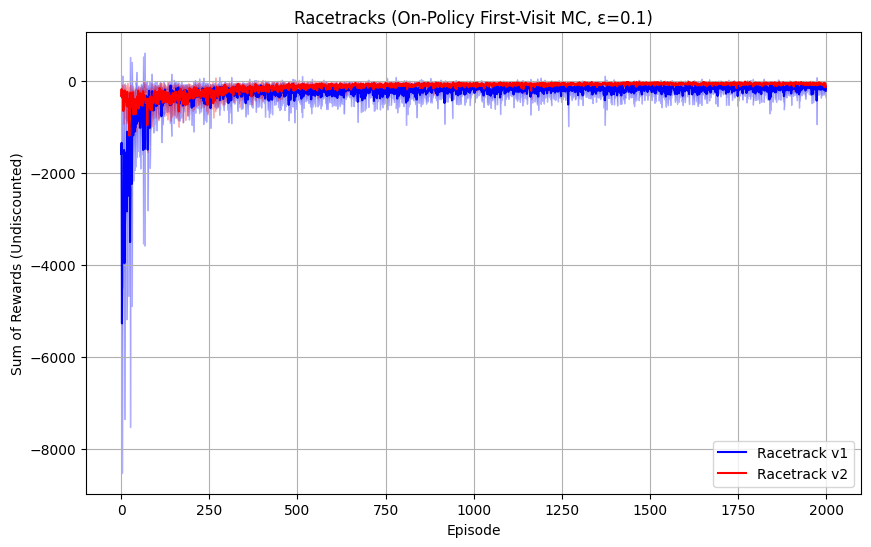

In [ ]:
random.seed(0)
np.random.seed(0)

num_trials = 10
num_episodes = 2000
epsilon = 0.1

# Racetrack v1 
results_v1 = run_multiple_trials("v1", num_trials=num_trials, num_episodes=num_episodes, epsilon=epsilon)

# Racetrack v2
results_v2 = run_multiple_trials("v2", num_trials=num_trials, num_episodes=num_episodes, epsilon=epsilon)
plot_learning_curves(results_v1=results_v1,results_v2=results_v2, title="Racetracks (On-Policy First-Visit MC, ε=0.1)")


## (b): Implement off-policy Monte-Carlo control. Please specify what behavior policy you are using.
    - Plot the learning curves for the two tracks
    - Using running trials number = 10 and episodes number = 2000

In [ ]:
""" CODE HERE YOUR IMPLEMENTATION for Q5-(b) """
# Implement here and use the plotting function above to plot the learning curve 

def get_behavior_action_and_prob(state, Q, epsilon, action_space):
    """
    Given the current state and Q-values, choose an action using an 
    ε-greedy behavior policy and return both the chosen action and its probability.
    
    state: list (e.g., [x, y, vx, vy])
    Q: dictionary with keys (state_tuple, action_tuple) -> value
    epsilon: exploration parameter
    action_space: list of possible actions (each action is a list, e.g. [dx, dy])
    
    Returns:
      action (list) and its probability (float) under the behavior policy.
    """
    state_key = tuple(state)
    n_actions = len(action_space)

    # Compute Q-values for each action (default to 0.0 if unseen)
    q_vals = np.array([Q.get((state_key, tuple(a)), 0.0) for a in action_space])
    max_q = np.max(q_vals)
    
    # Identify greedy action indices (ties are all considered greedy)
    greedy_indices = np.where(q_vals == max_q)[0]
    
    # Initialize uniform probabilities for exploration part
    probs = np.full(n_actions, epsilon / n_actions)
    # Add rest to greedy actions
    for idx in greedy_indices:
        probs[idx] += (1 - epsilon) / len(greedy_indices)
    # Sample an action from this probability distribution
    chosen_index = np.random.choice(n_actions, p=probs)
    return action_space[chosen_index], probs[chosen_index]

def mc_control_off_policy(env, num_episodes, epsilon, gamma=1.0):
    """
    Off-policy first-visit Monte Carlo control using weighted importance sampling.
    
    Args:
      env: An instance of the Racetrack environment.
      num_episodes: Number of episodes to run.
      epsilon: Parameter for the ε-greedy behavior policy.
      gamma: Discount factor.
      
    Returns:
      Q: Dictionary mapping (state, action) to value estimates.
      returns_per_episode: List of episode returns (sum of rewards per episode).
    """
    Q = {}  # state-action value estimates; keys: (state_tuple, action_tuple)
    C = {}  # cumulative weight sums; keys: (state_tuple, action_tuple)
    returns_per_episode = []
    action_space = env.action_space

    for episode_i in range(num_episodes):
        episode = []  # will store tuples: (state, action, reward, b_prob)
        state, _, done = env.reset()
        while not done:
            action, b_prob = get_behavior_action_and_prob(state, Q, epsilon, action_space)
            next_state, reward, done = env.step(state, action)
            episode.append((state, action, reward, b_prob))
            state = next_state

        # For simplicity, we use the (undiscounted) sum of rewards as the return
        G = sum([r for (_, _, r, _) in episode])
        returns_per_episode.append(G)

        # Off-policy weighted importance sampling update
        W = 1.0
        Gt = 0.0
        # Process the episode in reverse order
        for t in range(len(episode) - 1, -1, -1):
            s, a, r, b_prob = episode[t]
            Gt = gamma * Gt + r
            s_key = tuple(s)
            a_key = tuple(a)
            # Update cumulative weight
            C[(s_key, a_key)] = C.get((s_key, a_key), 0.0) + W
            # Incremental update of Q(s,a)
            old_val = Q.get((s_key, a_key), 0.0)
            Q[(s_key, a_key)] = old_val + (W / C[(s_key, a_key)]) * (Gt - old_val)
            # Update target policy for state s: greedy with respect to Q
            q_vals = [Q.get((s_key, tuple(act)), 0.0) for act in action_space]
            greedy_index = np.argmax(q_vals)
            greedy_action = action_space[greedy_index]
            # If the action taken does not match the greedy action, break
            if tuple(a) != tuple(greedy_action):
                break
            # Otherwise, update the weight
            W = W / b_prob
            if W == 0:
                break

    return Q, returns_per_episode

def run_multiple_trials_offpolicy(version, num_trials=10, num_episodes=2000, epsilon=0.1, gamma=1.0):
    """
    Runs the off-policy MC control on the Racetrack (v1 or v2) domain for multiple trials.
    
    Returns an array of shape (num_trials, num_episodes) with the return (sum of rewards)
    for each episode.
    """
    all_returns = []
    for trial in range(num_trials):
        env = Racetrack(version=version)
        _, ep_returns = mc_control_off_policy(env, num_episodes, epsilon, gamma)
        all_returns.append(ep_returns)
    return np.array(all_returns)


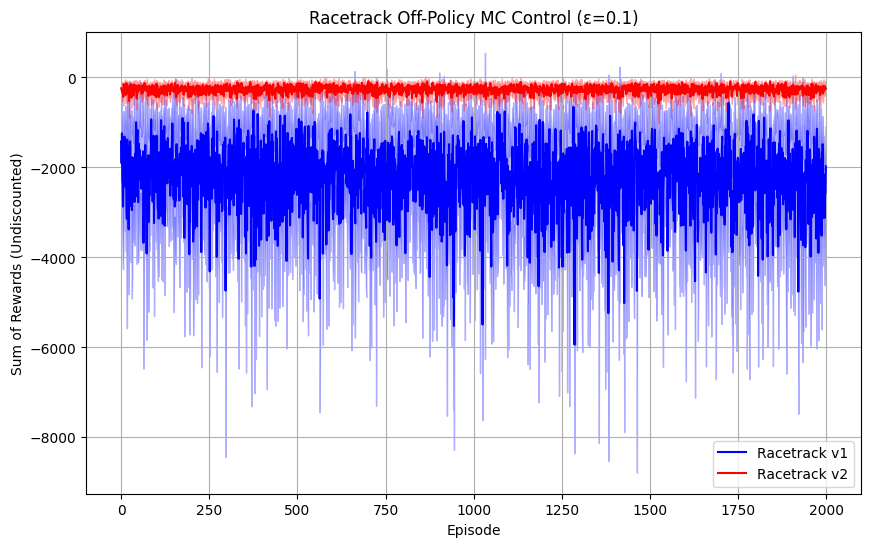

In [ ]:
random.seed(0)
np.random.seed(0)

num_trials = 10
num_episodes = 2000
epsilon = 0.1
gamma = 1.0

# Run off-policy MC control on Racetrack v1 and v2
results_v1 = run_multiple_trials_offpolicy("v1", num_trials=num_trials, num_episodes=num_episodes, epsilon=epsilon, gamma=gamma)
results_v2 = run_multiple_trials_offpolicy("v2", num_trials=num_trials, num_episodes=num_episodes, epsilon=epsilon, gamma=gamma)
plot_learning_curves(results_v1, results_v2, title="Racetrack Off-Policy MC Control (ε=0.1)")
